In [461]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve
from IPython.display import display, clear_output

In [462]:
class Cell2D:
    def __init__(self) -> None:
        pass
    
    def generate_grid(self,lx,ly,nx,ny,z):
        self.lx = lx
        self.ly = ly
        self.nx = nx
        self.ny = ny        
        self.dx = self.lx/(self.nx-1)
        self.dy = self.ly/(self.ny-1)
        self.z = z
    
    def define_timestep(self,T_t,d_t):
        self.T_t = T_t
        self.d_t = d_t        
    
    def define_thermal_properties(self, kx, ky, cp, q_gen, rho):
        self.kx = kx
        self.ky = ky
        self.cp = cp
        self.q_gen = q_gen
        self.rho = rho
    
    def create_explicit_matrices(self):        
        self.x = np.linspace(0,self.lx,self.nx,endpoint=True)
        self.y = np.linspace(0,self.ly,self.ny,endpoint=True)        
        self.X, self.Y = np.meshgrid(self.x,self.y)
        self.T = np.zeros((self.nx, self.ny))
        self.T_new = np.empty_like(self.T)    
        self.T_all = np.zeros((self.T_t, self.nx, self.ny))
    
    def create_implicit_matrices(self):
        self.T = np.zeros((self.nx, self.ny))
        self.T_new = np.zeros_like(self.T)    
    
    def calculate_courant_number(self):
        self.r_x = self.kx*self.d_t/(self.rho*self.cp*self.dx**2)
        self.r_y = self.ky*self.d_t/(self.rho*self.cp*self.dy**2)

    def set_initial_conditions(self, T_init):        
        self.T[:,:] = T_init
    
    def set_boundary_conditions(self,h,T_inf,side):
        return    

    def solve_explicit_equations(self):
        for dt in range(0,self.T_t):
            clear_output(wait=True)
            display("Iterating step ... " + str(dt),display_id=True)
            self.T_all[dt,:,:] = self.T[:,:]
            for i in range(1,self.nx-1):
                for j in range(1,self.ny-1):    
                    q_stored_factor = self.d_t/(self.rho*self.cp)
                    dT_x = self.kx*(self.T[i+1,j]-2*self.T[i,j]+self.T[i-1,j])/self.dx**2
                    dT_y = self.ky*(self.T[i,j+1]-2*self.T[i,j]+self.T[i,j-1])/self.dy**2
                    q_generated = self.q_gen*(self.dx*self.dy*self.z)/(self.lx*self.ly*self.z)
                    self.T_new[i,j] = self.T[i,j] + q_stored_factor*(dT_x+dT_y+q_generated)
            self.T[:,:] = self.T_new[:,:]
    
    def solve_implicit_equations(self):
        main_diag = (1+2*self.r_x+2*self.r_y)*np.ones(self.nx*self.ny)
        x_diag = -self.r_x*np.ones(self.nx*self.ny-1)        
        y_diag = -self.r_y*np.ones(self.nx*self.ny-self.ny)        
        for i in range(1,self.nx):
            x_diag[i*self.ny-1] = 0
        diagonals = [main_diag, x_diag, x_diag, y_diag, y_diag]
        offsets = [0,-1,1,-self.ny, self.ny]
        A_sparse = diags(diagonals, offsets, format="csc")

        for dt in range(0,self.T_t):
            clear_output(wait=True)
            display("Iterating step ... " + str(dt),display_id=True)
            T_flat = self.T.flatten()
            B = T_flat+self.q_gen*(self.dx*self.dy)/(self.lx*self.ly)*self.d_t
            B[0:self.ny] = 300
            B[-self.ny:0] = 300    
            for i in range(0, self.nx):
                B[i*self.nx] = 300
                B[i*self.nx+(self.ny-1)] = 300
            T_new_flat = spsolve(A_sparse,B)
            self.T = T_new_flat.reshape((self.nx, self.ny))

In [463]:
# cell = Cell2D()
# cell.generate_grid(0.115,0.105,100,100,0.022)
# cell.define_timestep(5000,1e-5)
# cell.define_thermal_properties(47,47,1100,0.4,2032)
# cell.create_explicit_matrices()
# cell.set_initial_conditions(300)
# cell.solve_explicit_equations()

In [464]:
cell = Cell2D()
cell.generate_grid(0.115,0.105,100,100,0.022)
cell.define_timestep(500,1)
cell.define_thermal_properties(47,47,1100,72000,2032)
cell.calculate_courant_number()
cell.create_implicit_matrices()
cell.set_initial_conditions(300)
cell.solve_implicit_equations()

'Iterating step ... 499'

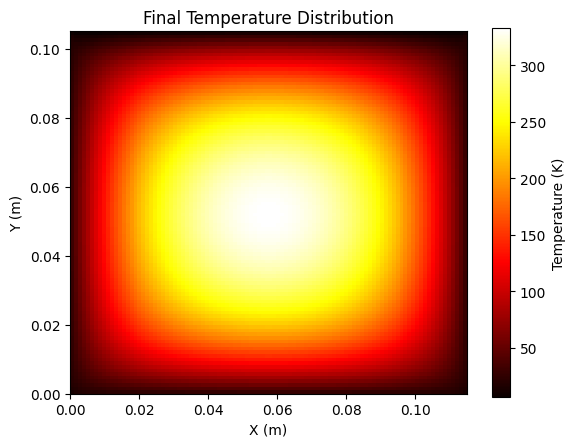

In [465]:
plt.imshow(cell.T, cmap='hot', origin='lower', extent=[0, cell.lx, 0, cell.ly])
plt.colorbar(label='Temperature (K)')
plt.title('Final Temperature Distribution')
plt.xlabel('X (m)')
plt.ylabel('Y (m)')
plt.show()